In [1]:
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

sys.path.insert(1, '../')
from data import load_narx_data, load_data, convert_to_narx
from model import Narx
from util_fun import calculate_error_nrms

In [30]:
def narx_sim_nrms(model, n_a, n_b, x_data, y_data, device, n_val_samples=3000):
     #init upast and ypast as lists.
    upast = [0]*n_b 
    ypast = [0]*n_a 

    x_data, y_data =[x[:n_val_samples] for x in [x_data, y_data]]
    ylist = []
    for unow in x_data.cpu().detach().numpy():
        #compute the current y given by f
        narx_input=torch.as_tensor(np.concatenate([upast,ypast])[None,:]).double()
        narx_input=narx_input.to(device)
        ynow = model.forward(narx_input).cpu().detach().item()
        
        #update past arrays
        upast.append(unow)
        upast.pop(0)
        ypast.append(ynow)
        ypast.pop(0)
        
        #save result
        ylist.append(ynow)
        
    NRMS=calculate_error_nrms(np.array(ylist), y_data)
    return NRMS

In [35]:
x,y = load_data()
x_train, x_val, y_train, y_val =train_test_split(x, y, shuffle=False)


In [37]:
n_epochs=int(5e2)
n_hidden_nodes=50
na_list=[*range(3,8)]
nb_list=[*range(14,26)]
final_losses=np.ndarray((len(na_list),len(nb_list)))
final_best_NRMSs=np.ndarray((len(na_list),len(nb_list)))
simulation_NRMSs=np.ndarray((len(na_list),len(nb_list)))
best_sim_NRMS=float('inf')
best_sim_model=None

In [39]:
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):

        # construct NARX data
        x_train_temp, y_train_temp = convert_to_narx(x_train, y_train,n_a, n_b)
        x_val_temp, y_val_temp = convert_to_narx(x_val, y_val,n_a, n_b)
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        x_train_temp, x_val_temp, y_train_temp, y_val_temp=[x.to(device) for x in [x_train_temp, x_val_temp, y_train_temp, y_val_temp]]

        # initialise comparison values and results lists
        best_NRMS=float('inf')
        best_model=None
        losses=[]
        NRMSs=[]
        best_NRMSs=[]

        model = Narx(x_train_temp.shape[1], n_hidden_nodes).to(device)
        optimizer = torch.optim.Adam(model.parameters()) 
        for epoch in range(n_epochs): 
            Loss = torch.mean((model(x_train_temp)-y_train_temp)**2) 
            optimizer.zero_grad() 
            Loss.backward() 
            optimizer.step() 
            if (epoch+1)%min((n_epochs//20),1000)==0:
                print(f"current run: {n_a, n_b}, epoch: {epoch+1}, Loss: {Loss.item()}") 
                NRMS=calculate_error_nrms(model.forward(x_val_temp), y_val_temp)
                if NRMS < best_NRMS:
                    best_NRMS=NRMS
                    best_model=deepcopy(model)
                    print(f"current RMS: {NRMS}, best RMS: {best_NRMS}")
                losses.append(Loss.item())
                NRMSs.append(NRMS)
                best_NRMSs.append(best_NRMS)

        # store results
        final_losses[i,j]=losses[-1]
        final_best_NRMSs[i,j]=best_NRMSs[-1]
        sim_NRMS=narx_sim_nrms(best_model, n_a, n_b, x_val, y_val, device)
        simulation_NRMSs[i,j]=sim_NRMS
        msg=f"current run: {n_a, n_b}, sim NRMS: {simulation_NRMSs[i,j]}"
        if sim_NRMS< best_sim_NRMS:
            best_sim_model=deepcopy(best_model)
            msg+=f". This is better than last sim best:{best_sim_NRMS} > {sim_NRMS}"
            best_sim_NRMS=sim_NRMS
        print(msg) 



current run: (3, 14), epoch: 25, Loss: 0.14808941922532376
current RMS: 0.7873671591910069, best RMS: 0.7873671591910069
current run: (3, 14), epoch: 50, Loss: 0.10971691831342946
current RMS: 0.6811039628050367, best RMS: 0.6811039628050367
current run: (3, 14), epoch: 75, Loss: 0.09700161858902678
current RMS: 0.6394498832032613, best RMS: 0.6394498832032613
current run: (3, 14), epoch: 100, Loss: 0.08630370516106564
current RMS: 0.6031168834582208, best RMS: 0.6031168834582208
current run: (3, 14), epoch: 125, Loss: 0.07589833353983216
current RMS: 0.5654088140162951, best RMS: 0.5654088140162951
current run: (3, 14), epoch: 150, Loss: 0.06548253223758106
current RMS: 0.5248865479838457, best RMS: 0.5248865479838457
current run: (3, 14), epoch: 175, Loss: 0.055387932995752044
current RMS: 0.4825398790305613, best RMS: 0.4825398790305613
current run: (3, 14), epoch: 200, Loss: 0.04625260863166986
current RMS: 0.440817515745073, best RMS: 0.440817515745073
current run: (3, 14), epoch:

C:\Users\Leo\AppData\Local\Temp\ipykernel_27016\418227314.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels([0]+na_list)
C:\Users\Leo\AppData\Local\Temp\ipykernel_27016\418227314.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels([0]+na_list)


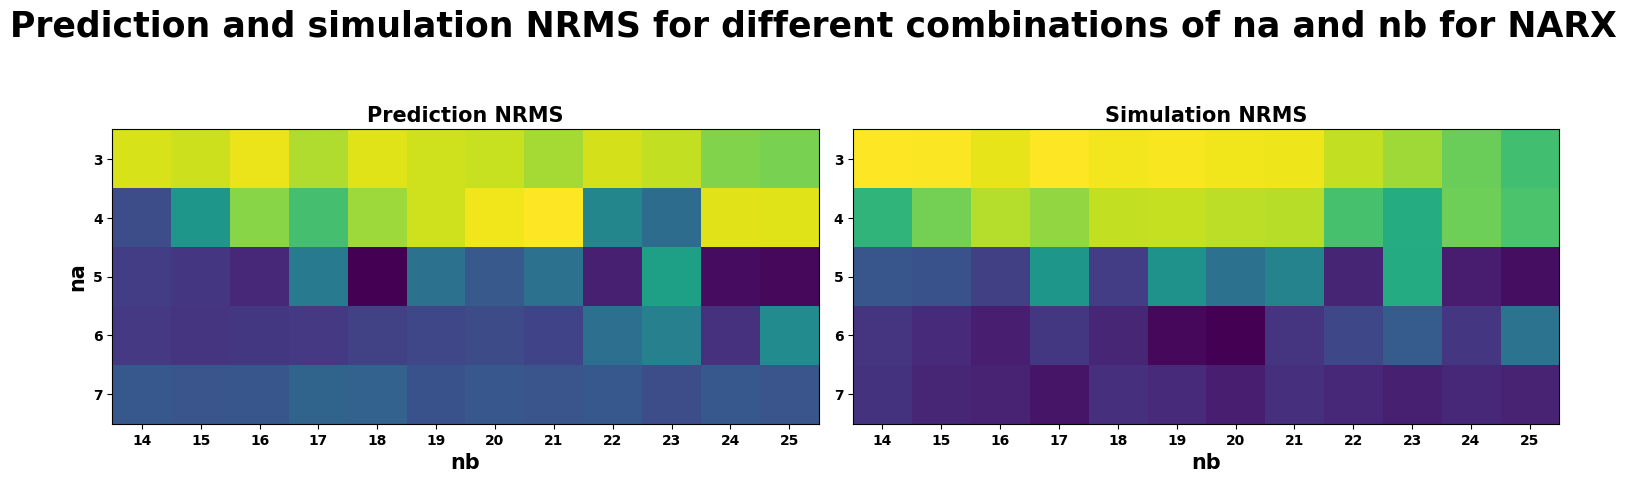

In [40]:
fs=15
fig = plt.figure(figsize=(15, 5),layout='constrained')
ax1=fig.add_subplot(121)
ax1.imshow(final_best_NRMSs, interpolation='none', norm='log')
ax2=fig.add_subplot(122)
ax2.imshow(simulation_NRMSs, interpolation='none', norm='log')
ax1.set_title('Prediction NRMS',fontsize=fs)
ax2.set_title('Simulation NRMS',fontsize=fs)
fig.suptitle('Prediction and simulation NRMS for different combinations of na and nb for NARX', fontsize=25)
ax1.set_ylabel('na',fontsize=fs)
ax1.set_xlabel('nb',fontsize=fs)
ax2.set_xlabel('nb',fontsize=fs)
ax1.set_yticklabels([0]+na_list)
ax1.set_xticks([*range(len(nb_list))],nb_list)
ax2.set_yticklabels([0]+na_list)
ax2.set_xticks([*range(len(nb_list))],nb_list)

In [42]:
params = np.zeros((len(na_list), len(nb_list), 2))
for i, n_a in enumerate(na_list):
    for j, n_b in enumerate(nb_list):
        params[i, j, :] = [n_a, n_b]

min_arg = np.unravel_index(final_best_NRMSs.argmin(keepdims=True), final_best_NRMSs.shape)
best_na, best_nb = params[min_arg].ravel()
print(f"Best parameters by prediction NRMS: na= {best_na}, nb= {best_nb}")
min_arg = np.unravel_index(simulation_NRMSs.argmin(keepdims=True), simulation_NRMSs.shape)
best_na, best_nb = params[min_arg].ravel()
f"Best parameters by simulation NRMS: na= {best_na}, nb= {best_nb}"

Best parameters by prediction NRMS: na= 5.0, nb= 18.0


'Best parameters by simulation NRMS: na= 6.0, nb= 20.0'

In [27]:
n_hidden_list=[10,20,50,100]

best_NRMS=float('inf')
best_model=None
losses=[]
RMSs=[]
best_RMSs=[]
n_a=5
n_b=1
final_losses=[]
final_best_RMSs=[]
for n_hidden_nodes in n_hidden_list:
    x,y = load_narx_data(n_a, n_b)
    x_train, x_val, y_train, y_val =train_test_split(x, y, shuffle=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    x_train, x_val, y_train, y_val=[x.to(device) for x in [x_train, x_val, y_train, y_val]]
    best_NRMS=float('inf')
    best_model=None
    losses=[]
    RMSs=[]
    best_RMSs=[]

    model = Narx(x_train.shape[1], n_hidden_nodes).to(device) #a=)
    optimizer = torch.optim.Adam(model.parameters()) #a)
    for epoch in range(n_epochs): #a)
        Loss = torch.mean((model(x_train)-y_train)**2) #a)
        optimizer.zero_grad() #a)
        Loss.backward() #a)
        optimizer.step() #a)
        if (epoch+1)%min((n_epochs//20),1000)==0: #a) monitor
            print(f"current run: {n_hidden_nodes}, epoch: {epoch+1}, Loss: {Loss.item()}") #a)
            RMS=np.mean((y_val.detach().cpu().numpy()-model.forward(x_val).detach().cpu().numpy())**2)**0.5
            if RMS < best_NRMS:
                best_NRMS=RMS
                best_model=deepcopy(model)
                print(f"current RMS: {RMS}, best RMS: {best_NRMS}")
            losses.append(Loss.item())
            RMSs.append(RMS)
            best_RMSs.append(best_NRMS)
    final_losses.append(losses[-1])
    final_best_RMSs.append(best_RMSs[-1])

current run: 10, epoch: 2, Loss: 0.24165140321723894
current RMS: 0.5025144542714477, best RMS: 0.5025144542714477
current run: 10, epoch: 4, Loss: 0.23403606179390396
current RMS: 0.4948659855087321, best RMS: 0.4948659855087321
current run: 10, epoch: 6, Loss: 0.22684853999299256
current RMS: 0.48754596360070424, best RMS: 0.48754596360070424
current run: 10, epoch: 8, Loss: 0.22009815202829622
current RMS: 0.4805776506361994, best RMS: 0.4805776506361994
current run: 10, epoch: 10, Loss: 0.21379074607971968
current RMS: 0.47398105850735595, best RMS: 0.47398105850735595
current run: 10, epoch: 12, Loss: 0.20792832878146797
current RMS: 0.46777218374132795, best RMS: 0.46777218374132795
current run: 10, epoch: 14, Loss: 0.2025087624773525
current RMS: 0.4619623060668021, best RMS: 0.4619623060668021
current run: 10, epoch: 16, Loss: 0.19752555586345721
current RMS: 0.4565573968939976, best RMS: 0.4565573968939976
current run: 10, epoch: 18, Loss: 0.19296776793953402
current RMS: 0.45

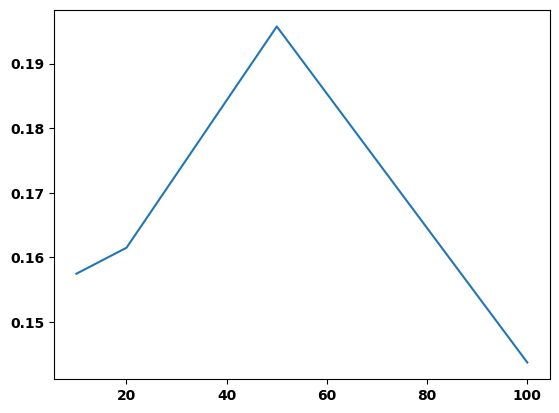

In [28]:
plt.plot(n_hidden_list,final_losses)